In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [2]:
plt.style.use('ggplot')
plt.style.use('seaborn-bright')

In [11]:
bb_usage_info = pd.read_excel("data/2.1 BB Usage Information.xlsx")  
bb_usage_info

,event_source.hash,upload,download,duration,ym
0,97f49f125b5091510366b7ed202aa812,301208959,706750143,37554,202107
1,8c04b64e4e3e94a6194b084110e01043,434569120,9643579465,203150,202104
2,292d4e6f305ea01af22802f16882c817,155351309,5068672660,871979,202107
3,8c04b64e4e3e94a6194b084110e01043,175960806,3584919166,213062,202106
4,40ec397ea821e66dd93065a3b8e8307f,6549583686,380182019793,1800576,202102
...,...,...,...,...,...
546705,7c8e9c38c6cfc2bde0d9bf35f544b2cb,466080238,14254807609,680110,202103
546706,3fdae19709fc5857acc14423bab3a93e,839666411,7847458006,276493,202011
546707,67c088869be9d064e702c2ba65a0f252,210069416,2497186286,140187,202106
546708,67c088869be9d064e702c2ba65a0f252,216196814,653697953,106229,202107


In [16]:
bb_usage_info.dropna(subset = ["upload","download","duration"],inplace=True)
bb_usage_info.shape

(546710, 5)

In [17]:
bb_usage_info.rename(columns = {"ym": "year-month"}, inplace = True)

In [18]:
bb_usage_info.isnull().sum(axis=0)

event_source.hash    0
upload               0
download             0
duration             0
year-month           0
dtype: int64

In [19]:
bb_usage_info['duration'].fillna(0)
bb_usage_info['upload'].fillna(0)
bb_usage_info['download'].fillna(0)

0            706750143
1           9643579465
2           5068672660
3           3584919166
4         380182019793
              ...     
546705     14254807609
546706      7847458006
546707      2497186286
546708       653697953
546709      8615159154
Name: download, Length: 546710, dtype: int64

# Phase 1

## Usage Ranking

- 1. Pivot by year-month
- 2. Bin by Upload/Download/Duration
- 3. Usage Rank
- 4. Labling usage

In [21]:
bb_usage_info['Usage'] = bb_usage_info.loc[:,['upload','download']].sum(axis=1)
bb_usage_info = bb_usage_info.drop(['upload','download'], axis=1)
bb_usage_info


,event_source.hash,duration,year-month,Usage
0,97f49f125b5091510366b7ed202aa812,37554,202107,1007959102
1,8c04b64e4e3e94a6194b084110e01043,203150,202104,10078148585
2,292d4e6f305ea01af22802f16882c817,871979,202107,5224023969
3,8c04b64e4e3e94a6194b084110e01043,213062,202106,3760879972
4,40ec397ea821e66dd93065a3b8e8307f,1800576,202102,386731603479
...,...,...,...,...
546705,7c8e9c38c6cfc2bde0d9bf35f544b2cb,680110,202103,14720887847
546706,3fdae19709fc5857acc14423bab3a93e,276493,202011,8687124417
546707,67c088869be9d064e702c2ba65a0f252,140187,202106,2707255702
546708,67c088869be9d064e702c2ba65a0f252,106229,202107,869894767


### BB Usage Trend Analysis

In [22]:
bb_usage_for_plot = bb_usage_info
bb_usage_for_plot["year-month"] = bb_usage_for_plot["year-month"].astype("category")

In [23]:
bb_usage_for_plot.groupby("year-month").sum()

,duration,Usage
year-month,,
202011,149978697174,3945203867761838
202012,82089511910,2015976699449969
202101,83158783908,2063905348829356
202102,80034272869,2026087217763413
202103,89461120930,2209671574072926
202104,95935636055,2912243632422726
202105,95935636055,2912243632422726
202106,101375757797,3215930128661097
202107,110288933602,3235825604256620


Text(0.5, 0.98, 'Broadband Duration (in hours) with Time')

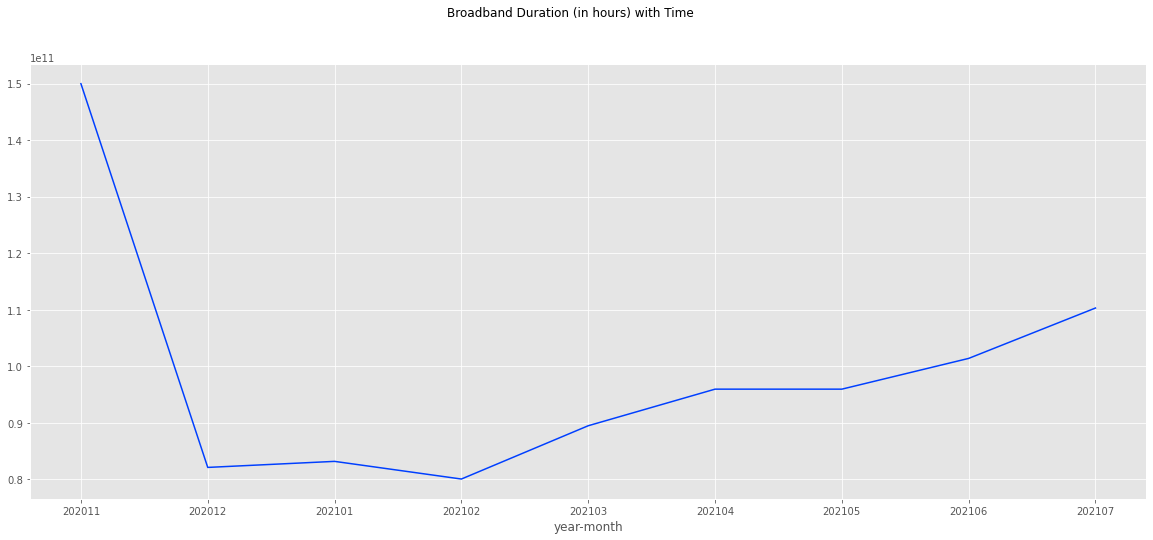

In [24]:
plt.figure(figsize=(20,8))
bb_usage_for_plot.groupby("year-month").sum()["duration"].plot()
plt.suptitle("Broadband Duration (in hours) with Time")

Text(0.5, 0.98, 'BroadBand Usage(in Bytes) with Time')

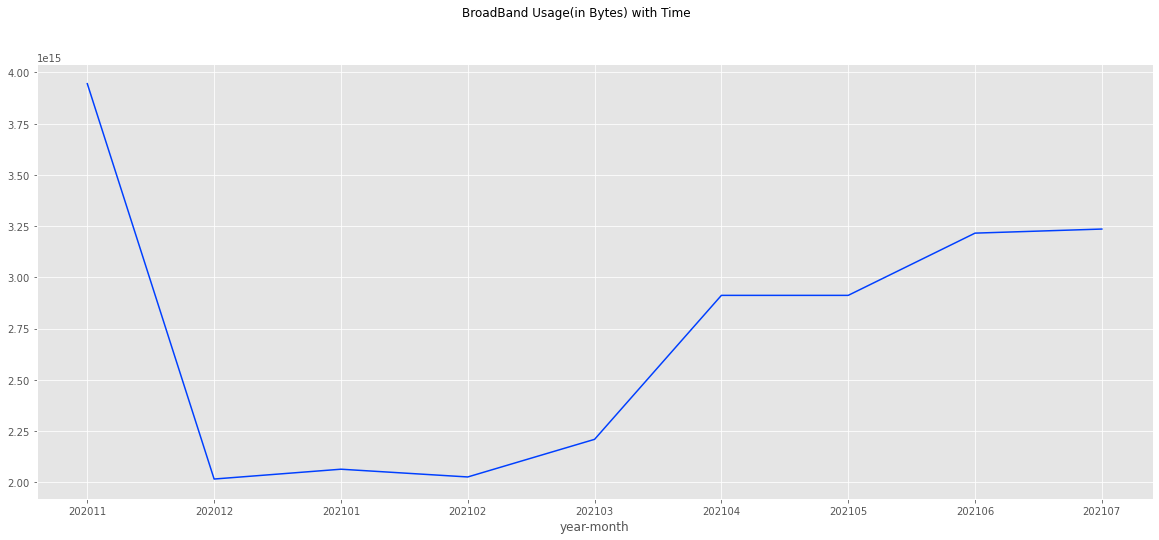

In [26]:
plt.figure(figsize=(20,8))
bb_usage_for_plot.groupby("year-month").sum()["Usage"].plot()
plt.suptitle("BroadBand Usage(in Bytes) with Time")

In [28]:
pivot_bb_usage_info = pd.pivot_table(bb_usage_info,index=['event_source.hash'],columns=['year-month'], aggfunc=np.sum, fill_value=0)
pivot_bb_usage_info

Usage                              \
year-month                              202011        202012        202101   
event_source.hash                                                            
59186358517212700922248718974976  141096774074   74054472154   61547743183   
00007cd39df96b9cf99fa19bca33862c  103960591866   40247289611   37426192851   
000084a38b0fa5ca77e7989aa5eb2d06   26491414668    7799184207    6259879627   
0000b72cb5dd05389b70e07ae2eaebd9   67419687238   14256871892   13973702454   
0000e468c37a20fddabc55cf098344ae  185201963070  105436360099   83117187139   
...                                        ...           ...           ...   
fffc95756b7dccbd011d78c8a7d41e6b             0             0             0   
fffdd1950a0cc6eb6e701bb732abadac  268917937894  133022624370  137236071959   
fffdede40561fb7b84c4c3941dec8e79             0             0             0   
fffe637a366b3a25df9fbe75aea241b1             0             0             0   
fffec93ce3fdf1421bce8728acdb866c   55602977906   29386127703   50961565980   

                                                                            \
year-month                              202102        202103        202104   
event_source.hash                                                            
59186358517212700922248718974976   60824640266   96138883131   70215194633   
00007cd39df96b9cf99fa19bca33862c   57914310565  112664695537   68690147986   
000084a38b0fa5ca77e7989aa5eb2d06    7933038960    7376655398   11561267658   
0000b72cb5dd05389b70e07ae2eaebd9    9606134310   10904952209   11543687692   
0000e468c37a20fddabc55cf098344ae  109372811289   93314091697  103880723764   
...                                        ...           ...           ...   
fffc95756b7dccbd011d78c8a7d41e6b             0             0             0   
fffdd1950a0cc6eb6e701bb732abadac  135468917498  132585102014  139557825935   
fffdede40561fb7b84c4c3941dec8e79             0             0   35032177403   
fffe637a366b3a25df9fbe75aea241b1             0             0             0   
fffec93ce3fdf1421bce8728acdb866c   30007653948   30548680595   27090657631   

                                                                            \
year-month                              202105        202106        202107   
event_source.hash                                                            
59186358517212700922248718974976   70215194633  120321990647  117089985150   
00007cd39df96b9cf99fa19bca33862c   68690147986   46075206360   38057068658   
000084a38b0fa5ca77e7989aa5eb2d06   11561267658   19158655297    6668657151   
0000b72cb5dd05389b70e07ae2eaebd9   11543687692    6253501572    9887412478   
0000e468c37a20fddabc55cf098344ae  103880723764  107723740676   79986042379   
...                                        ...           ...           ...   
fffc95756b7dccbd011d78c8a7d41e6b             0             0   28740638619   
fffdd1950a0cc6eb6e701bb732abadac  139557825935  151249152737  182942426103   
fffdede40561fb7b84c4c3941dec8e79   35032177403   52884529360   39266188052   
fffe637a366b3a25df9fbe75aea241b1             0   19271823463   19124862693   
fffec93ce3fdf1421bce8728acdb866c   27090657631   29645777158   30184307097   

                                 duration                                      \
year-month                         202011   202012   202101   202102   202103   
event_source.hash                                                               
59186358517212700922248718974976  5163340  2091648  2527145  2203736  2691430   
00007cd39df96b9cf99fa19bca33862c  4419112  1489116  2371773  1491616  2166543   
000084a38b0fa5ca77e7989aa5eb2d06  4836510  2452504  2268992  2177386  1462897   
0000b72cb5dd05389b70e07ae2eaebd9  4994860  2607992  2619290  2286266  2452256   
0000e468c37a20fddabc55cf098344ae  2643026  1546044  1172596  1351639  1194570   
...                                   ...      ...      ...      ...      ...   
fffc95756b7dccbd011d78c8a7d41e6b 

In [29]:
pivot_bb_usage_info.columns

MultiIndex([(   'Usage', 202011),
            (   'Usage', 202012),
            (   'Usage', 202101),
            (   'Usage', 202102),
            (   'Usage', 202103),
            (   'Usage', 202104),
            (   'Usage', 202105),
            (   'Usage', 202106),
            (   'Usage', 202107),
            ('duration', 202011),
            ('duration', 202012),
            ('duration', 202101),
            ('duration', 202102),
            ('duration', 202103),
            ('duration', 202104),
            ('duration', 202105),
            ('duration', 202106),
            ('duration', 202107)],
           names=[None, 'year-month'])

In [35]:
bb_usage.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,Duration,year-month,Usage
count,13043.00000,13043.00000,13043.00000
mean,1521226.50564,201974.09438,22678527038.04807
std,870908.53424,44.13513,28481239994.13892
min,120.00000,201908.00000,0.00000
25%,739867.00000,201912.00000,6834388399.50000
50%,1518326.00000,202003.00000,13811012030.00000
75%,2427392.00000,202006.00000,27456020350.00000
max,2709612.00000,202008.00000,537118249202.00000


In [36]:
# binning usage
usage_bins = [0, 7057561283.25, 14188526279.5,28226707481.75, 537118249202.0]
for col in pivot_bb_usage_info['Usage'].columns:
    pivot_bb_usage_info['Usage'][col] = np.searchsorted(usage_bins, pivot_bb_usage_info['Usage'][col].values)
pivot_bb_usage_info['Usage']

<ipython-input-36-11a9924446b9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_bb_usage_info['Usage'][col] = np.searchsorted(usage_bins, pivot_bb_usage_info['Usage'][col].values)


year-month,201908,201910,201911,201912,202001,202002,202003,202004,202005,202006,202007,202008
PSTN.hash,,,,,,,,,,,,
00567a4a3c474aca1ce5cd6570648932,4,3,2,3,4,4,4,4,4,3,4,3
00724ae2470df1ed0fe919800d02517d,0,0,0,0,0,0,0,0,0,0,0,2
00a8c3e3baed0557c31ab9b68a086ed2,2,2,2,2,3,2,3,2,2,2,2,2
00cc5a820586ce291c0fa4c2a99a4816,0,0,0,0,1,1,0,0,1,1,1,2
00d1f690ec4af27702febbd0db6942c2,2,2,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...
feca6cdb74a4a95dec4fe88f3fb2f938,0,0,0,0,0,0,0,0,0,0,2,2
ff1093d5ef61bf46f8c88e9b7614e311,2,2,2,3,2,3,4,4,4,2,3,2
ff45fdfb4b6dac191aba17a281181d39,3,4,3,3,3,4,3,1,1,4,3,2


In [37]:
# binning duration
duration_bins = [0, 745381.25, 1522064.0, 2438034.0,2709612.0]
for col in pivot_bb_usage_info['Duration'].columns:
    pivot_bb_usage_info['Duration'][col] = np.searchsorted(duration_bins, pivot_bb_usage_info['Duration'][col].values)
pivot_bb_usage_info['Duration']

<ipython-input-37-e9ec739a43e9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pivot_bb_usage_info['Duration'][col] = np.searchsorted(duration_bins, pivot_bb_usage_info['Duration'][col].values)


year-month,201908,201910,201911,201912,202001,202002,202003,202004,202005,202006,202007,202008
PSTN.hash,,,,,,,,,,,,
00567a4a3c474aca1ce5cd6570648932,3,2,2,2,3,3,3,3,3,3,3,2
00724ae2470df1ed0fe919800d02517d,0,0,0,0,0,0,0,0,0,0,0,3
00a8c3e3baed0557c31ab9b68a086ed2,1,2,1,1,2,1,1,1,1,2,1,1
00cc5a820586ce291c0fa4c2a99a4816,0,0,0,0,1,1,0,0,2,2,2,3
00d1f690ec4af27702febbd0db6942c2,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
feca6cdb74a4a95dec4fe88f3fb2f938,0,0,0,0,0,0,0,0,0,0,2,2
ff1093d5ef61bf46f8c88e9b7614e311,1,2,2,2,1,1,2,3,3,2,1,1
ff45fdfb4b6dac191aba17a281181d39,3,3,3,4,4,3,4,4,4,4,3,3


In [38]:
pivot_bb_usage_info

Duration                                     \
year-month                         201908 201910 201911 201912 202001 202002   
PSTN.hash                                                                      
00567a4a3c474aca1ce5cd6570648932        3      2      2      2      3      3   
00724ae2470df1ed0fe919800d02517d        0      0      0      0      0      0   
00a8c3e3baed0557c31ab9b68a086ed2        1      2      1      1      2      1   
00cc5a820586ce291c0fa4c2a99a4816        0      0      0      0      1      1   
00d1f690ec4af27702febbd0db6942c2        1      1      1      1      1      1   
...                                   ...    ...    ...    ...    ...    ...   
feca6cdb74a4a95dec4fe88f3fb2f938        0      0      0      0      0      0   
ff1093d5ef61bf46f8c88e9b7614e311        1      2      2      2      1      1   
ff45fdfb4b6dac191aba17a281181d39        3      3      3      4      4      3   
ffb2ec238eba276f65157693ed329c7f        0      0      0      1      3      3   
ffd697d66cc01c8897ce3e37d693673a        2      0      0      0      0      0   

                                                              ...  Usage  \
year-month                       202003 202004 202005 202006  ... 201911   
PSTN.hash                                                     ...          
00567a4a3c474aca1ce5cd6570648932      3      3      3      3  ...      2   
00724ae2470df1ed0fe919800d02517d      0      0      0      0  ...      0   
00a8c3e3baed0557c31ab9b68a086ed2      1      1      1      2  ...      2   
00cc5a820586ce291c0fa4c2a99a4816      0      0      2      2  ...      0   
00d1f690ec4af27702febbd0db6942c2      1      1      1      1  ...      2   
...                                 ...    ...    ...    ...  ...    ...   
feca6cdb74a4a95dec4fe88f3fb2f938      0      0      0      0  ...      0   
ff1093d5ef61bf46f8c88e9b7614e311      2      3      3      2  ...      2   
ff45fdfb4b6dac191aba17a281181d39      4      4      4      4  ...      3   
ffb2ec238eba276f65157693ed329c7f      3      3      4      4  ...      0   
ffd697d66cc01c8897ce3e37d693673a      0      0      0      0  ...      0   

                                                                            \
year-month                       201912 202001 202002 202003 202004 202005   
PSTN.hash                                                                    
00567a4a3c474aca1ce5cd6570648932      3      4      4      4      4      4   
00724ae2470df1ed0fe919800d02517d      0      0      0      0      0      0   
00a8c3e3baed0557c31ab9b68a086ed2      2      3      2      3      2      2   
00cc5a820586ce291c0fa4c2a99a4816      0      1      1      0      0      1   
00d1f690ec4af27702febbd0db6942c2      2      2      2      2      2      2   
...                                 ...    ...    ...    ...    ...    ...   
feca6cdb74a4a95dec4fe88f3fb2f938      0      0      0      0      0      0   
ff1093d5ef61bf46f8c88e9b7614e311      3      2      3      4      4      4   
ff45fdfb4b6dac191aba17a281181d39      3      3      4      3      1      1   
ffb2ec238eba276f65157693ed329c7f      1      4      4      4      4      4   
ffd697d66cc01c8897ce3e37d693673a      0      0      0      0      0      0   

                                                       
year-month                       202006 202007 202008  
PSTN.hash                                              
00567a4a3c474aca1ce5cd6570648932      3      4      3  
00724ae2470df1ed0fe919800d02517d      0      0      2  
00a8c3e3baed0557c31ab9b68a086ed2      2      2      2  
00cc5a820586ce291c0fa4c2a99a4816      1      1      2  
00d1f690ec4af27702febbd0db6942c2      2      2      2  
...                                 ...    ...    ...  
feca6cdb74a4a95dec4fe88f3fb2f938      0      2      2  
ff1093d5ef61bf46f8c88e9b7614e311      2      3      2  
ff45fdfb4b6dac191aba17a281181d39      4      3      2  
ffb2ec238eba276f65157693ed329c7f      4      4      3  
ffd697d66cc01c8897ce3e37d6

In [39]:
year_month_list = pivot_bb_usage_info['Usage'].columns

In [40]:
# multplying bins to get usage rating
for col in year_month_list:
    pivot_bb_usage_info[col] = pivot_bb_usage_info['Usage'][col]  * pivot_bb_usage_info['Duration'][col]

### Justification
- https://www.researchgate.net/post/Can-I-combine-2-independent-variable-as-one-variable-in-a-model-Can-I-still-include-the-individual-variable-in-the-same-model-after-combing-the-two
- http://www.utstat.toronto.edu/~brunner/DataAnalysisText/Interactions.pdf

### More advanced methods
- Dimension reduction approaches?

## ToDO
- find a different approach other than product

### Usage ratings for year-month

In [41]:
pivot_bb_usage_info = pivot_bb_usage_info.drop(['Usage','Duration'], axis=1)
pivot_bb_usage_info

,201908,201910,201911,201912,202001,202002,202003,202004,202005,202006,202007,202008
year-month,,,,,,,,,,,,
PSTN.hash,,,,,,,,,,,,
00567a4a3c474aca1ce5cd6570648932,12,6,4,6,12,12,12,12,12,9,12,6
00724ae2470df1ed0fe919800d02517d,0,0,0,0,0,0,0,0,0,0,0,6
00a8c3e3baed0557c31ab9b68a086ed2,2,4,2,2,6,2,3,2,2,4,2,2
00cc5a820586ce291c0fa4c2a99a4816,0,0,0,0,1,1,0,0,2,2,2,6
00d1f690ec4af27702febbd0db6942c2,2,2,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...
feca6cdb74a4a95dec4fe88f3fb2f938,0,0,0,0,0,0,0,0,0,0,4,4
ff1093d5ef61bf46f8c88e9b7614e311,2,4,4,6,2,3,8,12,12,4,3,2


In [42]:
# scaling usage rating
scaler = MinMaxScaler()
for col in year_month_list:
    pivot_bb_usage_info[col] = scaler.fit_transform(pivot_bb_usage_info[col].values.reshape(-1,1))

<AxesSubplot:xlabel='None-year-month', ylabel='PSTN.hash'>

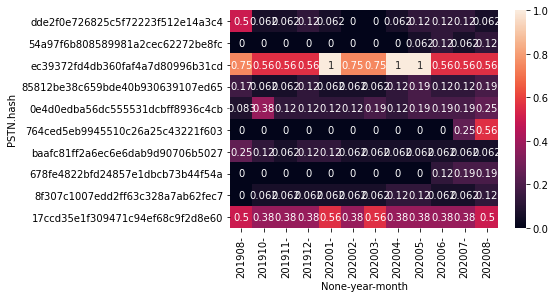

In [43]:
sns.heatmap(pivot_bb_usage_info[year_month_list].sample(n=10), annot=True)

<AxesSubplot:>

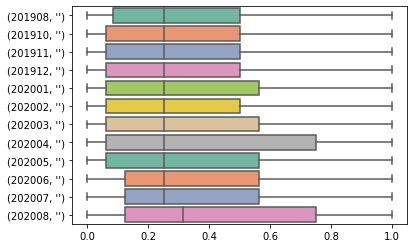

In [44]:
ax = sns.boxplot(data=pivot_bb_usage_info[[int(x) for x in year_month_list]], orient="h", palette="Set2")
ax

<AxesSubplot:ylabel='Density'>

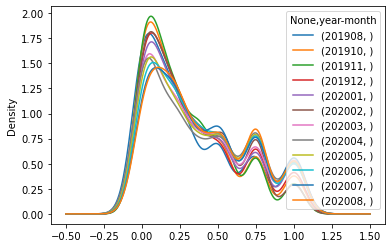

In [45]:
pivot_bb_usage_info[[int(x) for x in year_month_list]].plot(kind = 'density')

In [46]:
pivot_bb_usage_info['Usage_Rating_Scaled'] = pivot_bb_usage_info[year_month_list].sum(axis=1)/len(year_month_list)
pivot_bb_usage_info

,201908,201910,201911,201912,202001,202002,202003,202004,202005,202006,202007,202008,Usage_Rating_Scaled
year-month,,,,,,,,,,,,,
PSTN.hash,,,,,,,,,,,,,
00567a4a3c474aca1ce5cd6570648932,1.000000,0.375,0.2500,0.3750,0.7500,0.7500,0.7500,0.750,0.750,0.5625,0.7500,0.375,0.619792
00724ae2470df1ed0fe919800d02517d,0.000000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.0000,0.375,0.031250
00a8c3e3baed0557c31ab9b68a086ed2,0.166667,0.250,0.1250,0.1250,0.3750,0.1250,0.1875,0.125,0.125,0.2500,0.1250,0.125,0.175347
00cc5a820586ce291c0fa4c2a99a4816,0.000000,0.000,0.0000,0.0000,0.0625,0.0625,0.0000,0.000,0.125,0.1250,0.1250,0.375,0.072917
00d1f690ec4af27702febbd0db6942c2,0.166667,0.125,0.1250,0.1250,0.1250,0.1250,0.1250,0.125,0.125,0.1250,0.1250,0.125,0.128472
...,...,...,...,...,...,...,...,...,...,...,...,...,...
feca6cdb74a4a95dec4fe88f3fb2f938,0.000000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.2500,0.250,0.041667
ff1093d5ef61bf46f8c88e9b7614e311,0.166667,0.250,0.2500,0.3750,0.1250,0.1875,0.5000,0.750,0.750,0.2500,0.1875,0.125,0.326389


In [47]:
pivot_bb_usage_info.describe()

,201908,201910,201911,201912,202001,202002,202003,202004,202005,202006,202007,202008,Usage_Rating_Scaled
year-month,,,,,,,,,,,,,
count,1306.000000,1306.000000,1306.000000,1306.000000,1306.000000,1306.000000,1306.000000,1306.000000,1306.000000,1306.000000,1306.000000,1306.000000,1306.000000
mean,0.328931,0.310825,0.299914,0.327910,0.346861,0.322741,0.363419,0.376388,0.374856,0.376627,0.390027,0.391702,0.350850
std,0.323410,0.295865,0.281419,0.303084,0.315020,0.291014,0.323282,0.328423,0.320893,0.315067,0.317071,0.315250,0.262686
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005208
25%,0.083333,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.062500,0.125000,0.125000,0.125000,0.127170
50%,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.250000,0.312500,0.281250
75%,0.500000,0.500000,0.500000,0.500000,0.562500,0.500000,0.562500,0.750000,0.562500,0.562500,0.562500,0.750000,0.531250
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [48]:
# labling usage bins
bins = [0, 0.33, 0.66,1]
labels = ['LOW','MEDIUM','HIGH']
pivot_bb_usage_info['Usage_Rating_Categorical'] = pd.cut(pivot_bb_usage_info['Usage_Rating_Scaled'], bins=bins, labels=labels)
pivot_bb_usage_info

,201908,201910,201911,201912,202001,202002,202003,202004,202005,202006,202007,202008,Usage_Rating_Scaled,Usage_Rating_Categorical
year-month,,,,,,,,,,,,,,
PSTN.hash,,,,,,,,,,,,,,
00567a4a3c474aca1ce5cd6570648932,1.000000,0.375,0.2500,0.3750,0.7500,0.7500,0.7500,0.750,0.750,0.5625,0.7500,0.375,0.619792,MEDIUM
00724ae2470df1ed0fe919800d02517d,0.000000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.0000,0.375,0.031250,LOW
00a8c3e3baed0557c31ab9b68a086ed2,0.166667,0.250,0.1250,0.1250,0.3750,0.1250,0.1875,0.125,0.125,0.2500,0.1250,0.125,0.175347,LOW
00cc5a820586ce291c0fa4c2a99a4816,0.000000,0.000,0.0000,0.0000,0.0625,0.0625,0.0000,0.000,0.125,0.1250,0.1250,0.375,0.072917,LOW
00d1f690ec4af27702febbd0db6942c2,0.166667,0.125,0.1250,0.1250,0.1250,0.1250,0.1250,0.125,0.125,0.1250,0.1250,0.125,0.128472,LOW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
feca6cdb74a4a95dec4fe88f3fb2f938,0.000000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.2500,0.250,0.041667,LOW
ff1093d5ef61bf46f8c88e9b7614e311,0.166667,0.250,0.2500,0.3750,0.1250,0.1875,0.5000,0.750,0.750,0.2500,0.1875,0.125,0.326389,LOW


In [49]:
# adding category "NO" 
pivot_bb_usage_info['Usage_Rating_Categorical'] = pivot_bb_usage_info['Usage_Rating_Categorical'].cat.add_categories("NO")
pivot_bb_usage_info.loc[pivot_bb_usage_info['Usage_Rating_Scaled'] == 0.0, 'Usage_Rating_Categorical'] = "NO"
pivot_bb_usage_info[(pivot_bb_usage_info['Usage_Rating_Scaled'] == 0.0)]

,201908,201910,201911,201912,202001,202002,202003,202004,202005,202006,202007,202008,Usage_Rating_Scaled,Usage_Rating_Categorical
year-month,,,,,,,,,,,,,,
PSTN.hash,,,,,,,,,,,,,,


### Fina Result: Usage Ratings

In [50]:
pivot_bb_usage_info

,201908,201910,201911,201912,202001,202002,202003,202004,202005,202006,202007,202008,Usage_Rating_Scaled,Usage_Rating_Categorical
year-month,,,,,,,,,,,,,,
PSTN.hash,,,,,,,,,,,,,,
00567a4a3c474aca1ce5cd6570648932,1.000000,0.375,0.2500,0.3750,0.7500,0.7500,0.7500,0.750,0.750,0.5625,0.7500,0.375,0.619792,MEDIUM
00724ae2470df1ed0fe919800d02517d,0.000000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.0000,0.375,0.031250,LOW
00a8c3e3baed0557c31ab9b68a086ed2,0.166667,0.250,0.1250,0.1250,0.3750,0.1250,0.1875,0.125,0.125,0.2500,0.1250,0.125,0.175347,LOW
00cc5a820586ce291c0fa4c2a99a4816,0.000000,0.000,0.0000,0.0000,0.0625,0.0625,0.0000,0.000,0.125,0.1250,0.1250,0.375,0.072917,LOW
00d1f690ec4af27702febbd0db6942c2,0.166667,0.125,0.1250,0.1250,0.1250,0.1250,0.1250,0.125,0.125,0.1250,0.1250,0.125,0.128472,LOW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
feca6cdb74a4a95dec4fe88f3fb2f938,0.000000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.000,0.000,0.0000,0.2500,0.250,0.041667,LOW
ff1093d5ef61bf46f8c88e9b7614e311,0.166667,0.250,0.2500,0.3750,0.1250,0.1875,0.5000,0.750,0.750,0.2500,0.1875,0.125,0.326389,LOW


In [51]:
pivot_bb_usage_info.to_csv("data/user_profile/BB_Usage_Categorical.csv")